## Option 2 — Search over mixed audio/text using noisy ASR (phoneme 3-grams)

This notebook implements: **Whisper ASR → g2p_en → phoneme 3-grams → cosine similarity → ranking + bar chart + top overlap**.

### Assignment Requirements:
- **2 clean text documents** (manually written)
- **2 ASR transcription documents** from audio files (with natural ASR errors)
- **Query**: 3-4 clean words that appear in the documents (some with ASR errors in the index)
- Index using **phoneme 3-grams** and retrieve using **cosine similarity**


In [11]:


"""Option 2 (IR): Phoneme 3-gram indexing and retrieval over mixed clean/noisy (ASR-like) text.

Pipeline: Whisper ASR → g2p_en → phoneme 3-grams → cosine similarity → ranking + bar chart + top overlap.

Requirements (in your environment):
  pip install openai-whisper g2p_en matplotlib nltk
"""

from __future__ import annotations

import math
import re
import sys
from collections import Counter
from dataclasses import dataclass
from typing import Iterable, List

import matplotlib.pyplot as plt


try:
    from g2p_en import G2p
except Exception as e:
    print(
        "ERROR: Could not import g2p_en. Install dependencies:\n"
        "  pip install g2p_en nltk matplotlib\n\n"
        f"Details: {e}",
        file=sys.stderr,
    )
    raise

try:
    import whisper
except Exception as e:
    print(
        "ERROR: Could not import whisper. Install it with:\n"
        "  pip install openai-whisper\n\n"
        f"Details: {e}",
        file=sys.stderr,
    )
    raise


_PUNCT_RE = re.compile(r"[^a-z0-9\s]+", re.IGNORECASE)
_WS_RE = re.compile(r"\s+")


@dataclass(frozen=True)
class Document:
    doc_id: str
    text: str


def normalize_text(text: str) -> str:
    """Lowercase and strip punctuation, then collapse whitespace."""
    text = text.lower()
    text = _PUNCT_RE.sub(" ", text)
    text = _WS_RE.sub(" ", text).strip()
    return text


def _ensure_nltk_data() -> None:
    """Try to download common NLTK resources used by g2p_en if missing (quietly)."""
    try:
        import nltk  # type: ignore

        # g2p_en relies on tokenization + POS tagging; recent NLTK versions
        # may require the *_eng tagger variant. Keep this best-effort and quiet.
        pkgs = (
            "cmudict",
            "punkt",
            "punkt_tab",  # some installs need this
            "averaged_perceptron_tagger",
            "averaged_perceptron_tagger_eng",
        )

        for pkg in pkgs:
            try:
                nltk.data.find(f"corpora/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.data.find(f"tokenizers/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.data.find(f"taggers/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.download(pkg, quiet=True)
            except Exception:
                # Best-effort only.
                pass
    except Exception:
        pass


def text_to_phonemes(text: str, g2p: G2p) -> List[str]:
    """Normalize text, then convert to a filtered phoneme token sequence (ARPAbet-like)."""
    norm = normalize_text(text)
    if not norm:
        return []

    raw = g2p(norm)

    phonemes: List[str] = []
    for tok in raw:
        if not tok or tok.isspace():
            continue
        # Keep ARPAbet-ish tokens, e.g. AH0, N, SH.
        if re.fullmatch(r"[A-Z]+[0-2]?", tok):
            phonemes.append(tok)
    return phonemes


def phoneme_ngrams(phonemes: List[str], n: int = 3) -> List[str]:
    """Generate phoneme n-grams (default: 3-grams) as 'PH1-PH2-PH3' strings."""
    if n <= 0 or len(phonemes) < n:
        return []
    return ["-".join(phonemes[i : i + n]) for i in range(len(phonemes) - n + 1)]


def vectorize(ngrams: Iterable[str]) -> Counter:
    """Convert an iterable of n-grams into a bag-of-ngrams count vector."""
    return Counter(ngrams)


def cosine_similarity(v1: Counter, v2: Counter) -> float:
    """Cosine similarity for sparse count vectors; safe for empty vectors."""
    if not v1 or not v2:
        return 0.0

    dot = 0.0
    # Iterate the smaller vector.
    if len(v1) > len(v2):
        v1, v2 = v2, v1
    for k, c in v1.items():
        dot += c * v2.get(k, 0)

    n1 = math.sqrt(sum(c * c for c in v1.values()))
    n2 = math.sqrt(sum(c * c for c in v2.values()))
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return float(dot / (n1 * n2))


def _snippet(text: str, n: int = 80) -> str:
    t = text[:n]
    return t + ("..." if len(text) > n else "")


def transcribe_audio(audio_path: str, model_name: str = "base") -> str:
    """
    Transcribe an audio file using OpenAI Whisper.
    Returns the transcribed text (may contain ASR errors).
    """
    model = whisper.load_model(model_name)
    result = model.transcribe(audio_path)
    return result["text"].strip()



## Step 1: Transcribe audio files using Whisper ASR

We transcribe the audio files to get ASR output (with natural transcription errors).


In [12]:
# Audio files to transcribe (ASR documents)
AUDIO_FILES = [
    ("D3_asr_female", "female.wav"),
    ("D4_asr_male", "male.wav"),
]

print("Transcribing audio files using Whisper ASR (base model)...")
print("=" * 60)

asr_transcriptions = {}
for doc_id, audio_file in AUDIO_FILES:
    print(f"\nTranscribing: {audio_file}")
    text = transcribe_audio(audio_file, model_name="base")
    asr_transcriptions[doc_id] = text
    print(f"  → {doc_id}: {text[:100]}{'...' if len(text) > 100 else ''}")

print("\n" + "=" * 60)
print("Transcription complete!")



Transcribing audio files using Whisper ASR (base model)...

Transcribing: female.wav


/Users/ramidaood/UNI/IR7/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


  → D3_asr_female: Author of the Danger Trail, Philip Steele, etc.

Transcribing: male.wav


/Users/ramidaood/UNI/IR7/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


  → D4_asr_male: Offer of the danger trail, Philip Steels, etc.

Transcription complete!


## Step 2: Build document collection (2 clean text + 2 ASR transcriptions)

- **D1_clean** and **D2_clean**: Manually written clean text documents
- **D3_asr_female** and **D4_asr_male**: ASR transcriptions from audio files (may contain natural ASR errors)


In [13]:
# Build the document collection: 2 clean text + 2 ASR transcriptions
# Clean documents match the ASR content (but without errors)
# ASR documents contain natural transcription errors

documents = [
    # Clean text documents (manually written, no errors)
    # These match the content of the ASR files but are correct
    Document(
        "D1_clean",
        "Author of the Danger Trail, Philip Steele, etc.",
    ),
    Document(
        "D2_clean",
        "The book Danger Trail was written by Philip Steele.",
    ),
    # ASR transcription documents (from audio files - may contain errors)
    # D3: "Philip Steele" (correct in this one)
    # D4: "Philip Steels" (ASR error: Steele → Steels)
    Document("D3_asr_female", asr_transcriptions.get("D3_asr_female", "")),
    Document("D4_asr_male", asr_transcriptions.get("D4_asr_male", "")),
]

print("Document Collection:")
print("=" * 60)
for d in documents:
    source = "CLEAN TEXT" if "clean" in d.doc_id else "ASR TRANSCRIPTION"
    print(f"\n[{source}] {d.doc_id}:")
    print(f"  {d.text[:120]}{'...' if len(d.text) > 120 else ''}")


Document Collection:

[CLEAN TEXT] D1_clean:
  Author of the Danger Trail, Philip Steele, etc.

[CLEAN TEXT] D2_clean:
  The book Danger Trail was written by Philip Steele.

[ASR TRANSCRIPTION] D3_asr_female:
  Author of the Danger Trail, Philip Steele, etc.

[ASR TRANSCRIPTION] D4_asr_male:
  Offer of the danger trail, Philip Steels, etc.


## Step 3: Index with phoneme 3-grams and retrieve using cosine similarity

- Convert each document to phonemes using **g2p_en**
- Generate **phoneme 3-grams** from the phoneme sequence
- Represent documents and query as **bag-of-phoneme-3grams** vectors
- Compute **cosine similarity** between query and each document
- Rank documents by similarity


In [14]:
from typing import Dict, Tuple

# Initialize g2p and ensure NLTK data is available
_ensure_nltk_data()
g2p = G2p()

# Query: 3-4 clean words (no errors)
# Query uses words that appear in the ASR transcriptions
# This allows us to see how ASR errors affect retrieval
# Words: "danger", "trail", "philip", "steele" appear in the documents
# D4 has ASR error: "Steele" → "Steels"
query = "danger trail philip steele"
assert 3 <= len(query.split()) <= 4, "Query must contain 3-4 words"

print("=" * 60)
print(f"Query (clean): {query}")
print("=" * 60)

# Convert query to phoneme 3-grams
q_ph = text_to_phonemes(query, g2p)
q_3g = phoneme_ngrams(q_ph, n=3)
q_vec = vectorize(q_3g)

print(f"\nQuery phonemes: {' '.join(q_ph)}")
print(f"Query 3-grams ({len(q_3g)} total): {q_3g[:5]}...")

# Index all documents
doc_vectors: Dict[str, Counter] = {}
doc_scores: List[Tuple[str, float]] = []

print("\n" + "-" * 60)
print("Documents (normalized snippets):")
print("-" * 60)

for d in documents:
    norm = normalize_text(d.text)
    print(f"\n• {d.doc_id}: {_snippet(norm)}")

    d_ph = text_to_phonemes(d.text, g2p)
    d_3g = phoneme_ngrams(d_ph, n=3)
    d_vec = vectorize(d_3g)

    doc_vectors[d.doc_id] = d_vec
    score = cosine_similarity(q_vec, d_vec)
    doc_scores.append((d.doc_id, score))
    
    print(f"  → {len(d_ph)} phonemes, {len(d_3g)} 3-grams, similarity={score:.4f}")


Query (clean): danger trail philip steele

Query phonemes: D EY1 N JH ER0 T R EY1 L F IH1 L AH0 P S T IY1 L
Query 3-grams (16 total): ['D-EY1-N', 'EY1-N-JH', 'N-JH-ER0', 'JH-ER0-T', 'ER0-T-R']...

------------------------------------------------------------
Documents (normalized snippets):
------------------------------------------------------------

• D1_clean: author of the danger trail philip steele etc
  → 32 phonemes, 30 3-grams, similarity=0.7303

• D2_clean: the book danger trail was written by philip steele
  → 33 phonemes, 31 3-grams, similarity=0.6286

• D3_asr_female: author of the danger trail philip steele etc
  → 32 phonemes, 30 3-grams, similarity=0.7303

• D4_asr_male: offer of the danger trail philip steels etc
  → 33 phonemes, 31 3-grams, similarity=0.7184


## Step 4: Display ranked results and visualization


RESULTS (ranked by cosine similarity over phoneme 3-grams)

Rank   doc_id                  score
------------------------------------
1      D1_clean               0.7303
2      D3_asr_female          0.7303
3      D4_asr_male            0.7184
4      D2_clean               0.6286

TOP OVERLAP (best doc: D1_clean, score=0.7303)

3-gram                query    doc  overlap
--------------------------------------------
L-F-IH1                   1      1        1
D-EY1-N                   1      1        1
JH-ER0-T                  1      1        1
EY1-N-JH                  1      1        1
R-EY1-L                   1      1        1
EY1-L-F                   1      1        1
AH0-P-S                   1      1        1
IH1-L-AH0                 1      1        1
S-T-IY1                   1      1        1
T-IY1-L                   1      1        1
P-S-T                     1      1        1
L-AH0-P                   1      1        1
N-JH-ER0                  1      1        1
ER0-T-R 

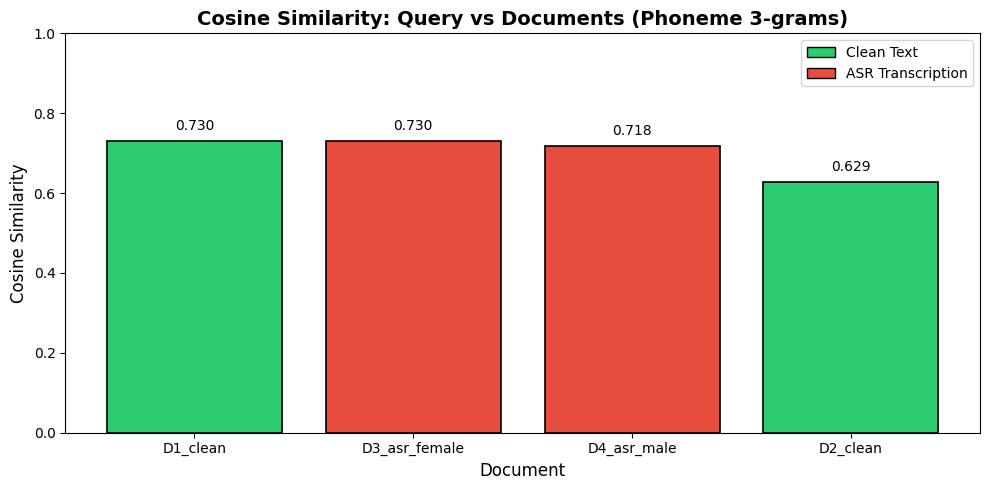

In [15]:
# Sort by similarity score (descending)
doc_scores.sort(key=lambda x: x[1], reverse=True)

print("=" * 60)
print("RESULTS (ranked by cosine similarity over phoneme 3-grams)")
print("=" * 60)
print(f"\n{'Rank':<6} {'doc_id':<18} {'score':>10}")
print("-" * 36)
for rank, (doc_id, score) in enumerate(doc_scores, 1):
    print(f"{rank:<6} {doc_id:<18} {score:>10.4f}")

# Top overlap section for best-ranked document
print("\n" + "=" * 60)
best_doc_id, best_score = doc_scores[0]
best_vec = doc_vectors[best_doc_id]

overlap = {k: min(q_vec.get(k, 0), best_vec.get(k, 0)) 
           for k in (q_vec.keys() & best_vec.keys())}
top_overlap = sorted(
    overlap.items(),
    key=lambda kv: (kv[1], q_vec[kv[0]] + best_vec[kv[0]]),
    reverse=True,
)[:15]

print(f"TOP OVERLAP (best doc: {best_doc_id}, score={best_score:.4f})")
print("=" * 60)

if not top_overlap:
    print("(no overlapping 3-grams)")
else:
    print(f"\n{'3-gram':<20} {'query':>6} {'doc':>6} {'overlap':>8}")
    print("-" * 44)
    for gram, ov in top_overlap:
        print(f"{gram:<20} {q_vec[gram]:>6} {best_vec[gram]:>6} {ov:>8}")

# Visualization: bar chart of cosine similarity per document
print("\n" + "=" * 60)
print("VISUALIZATION: Cosine Similarity Bar Chart")
print("=" * 60)

doc_ids = [doc_id for doc_id, _ in doc_scores]
scores = [score for _, score in doc_scores]

# Color bars: green for clean docs, orange for ASR docs
colors = ['#2ecc71' if 'clean' in d else '#e74c3c' for d in doc_ids]

plt.figure(figsize=(10, 5))
bars = plt.bar(doc_ids, scores, color=colors, edgecolor='black', linewidth=1.2)

plt.title("Cosine Similarity: Query vs Documents (Phoneme 3-grams)", fontsize=14, fontweight='bold')
plt.xlabel("Document", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.ylim(0.0, 1.0)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='Clean Text'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='ASR Transcription')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()
